### Explore meteorological data

In [186]:
import os
import zipfile
import pandas as pd
import glob
import keplergl
import geopandas as gpd
import matplotlib.pyplot as plt
import csv
from datetime import datetime
import re
import numpy as np
from pyproj import Proj
%run Meteo_utils.ipynb

In [2]:
# Drive folder with original data: https://drive.google.com/drive/folders/1me2IpDY3om6IRKv_WMT5W6Qw0r9DI74C

In [3]:
os.listdir('data')

['.DS_Store',
 '07-HGPT-MT-07.- Estacion Aeropuerto-20210505T205931Z-001.zip',
 'Estaciones_meteorologicas.csv',
 'Estaciones_meteorologicas_SW.csv',
 '02-HGPT-MT-06.- Estacion Baños-20210426T162523Z-001.zip',
 'Inventario Estaciones Meteo.xls',
 '.ipynb_checkpoints',
 'Estaciones_meteorologicas_SW.numbers',
 '02-HGPT-MT-06.- Estacion Baños']

In [4]:
### Read a sheet from an excel file
file = glob.glob('data/*.xls')[0]
sheets = pd.read_excel(file, None)
list(sheets.keys())
df = pd.read_excel(io=file, sheet_name=list(sheets.keys())[0], engine ='xlrd',skiprows = 1)

In [5]:
df = pd.read_csv('data/Estaciones_meteorologicas.csv')
df.head()

,fuente,numero,codigo,nombre,tipo,provincia,estado,fecha_instalacion,latitud,longitud,parametros_medicion
0,esta_inamhi,1,M0029,BAÑOS,CP,TUNGURAHUA,FUNCIONANDO,20-jun-62,12329.0,782505.0,"Temperatura Max, temperatura Min, Temperatura,..."
1,esta_inamhi,2,M0258,QUEROCHACA(UTA),CP,TUNGURAHUA,FUNCIONANDO,2-nov-85,12202.0,783620.0,"Temperatura Max, temperatura Min, Temperatura,..."
2,esta_inamhi,3,M1069,CALAMACA CONVENIO INAMHI HCPT,CP,TUNGURAHUA,FUNCIONANDO,4-jul-88,11634.0,784908.0,"Temperatura Max, temperatura Min, Temperatura,..."
3,esta_inamhi,4,M0126,PATATE,CO,TUNGURAHUA,FUNCIONANDO,1-may-63,11801.0,783000.0,"Temperatura Max, temperatura Min, Temperatura,..."
4,esta_inamhi,5,M0127,PILLARO,CO,TUNGURAHUA,FUNCIONANDO,1-Dec-63,11010.0,783310.0,"Temperatura Max, temperatura Min, Temperatura,..."


In [7]:
df.fuente.unique()

array(['esta_inamhi', 'esta_hgpt', 'esta_hgpt_sen'], dtype=object)

In [12]:
# Conversion from UTM to degrees
# https://ocefpaf.github.io/python4oceanographers/blog/2013/12/16/utm/
# EPSG:32717 (UTM 17S) (copy Proj4 format)
north = Proj("+proj=utm +zone=17 +north +ellps=WGS84 +datum=WGS84 +units=m +no_defs")
south = Proj("+proj=utm +zone=17 +south +ellps=WGS84 +datum=WGS84 +units=m +no_defs")

In [33]:
# UTM info : http://geokov.com/education/utm.aspx
# Northing coordinates use Equator as reference. For NH, Equator= 0. For SH , Equator = 10.000.000
# Easting coordinates use the false origin 500000 meters to the west of the central meridian of the UTM zone

# ESTA INAMHI data had lat = xxxS and long = xxxW 
## 17N
df.loc[df['fuente'] == 'esta_inamhi','lon_deg'], df.loc[df['fuente'] == 'esta_inamhi','lat_deg']= north(df[df['fuente'] == 'esta_inamhi']['longitud'].values, 
                                                                                          df[df['fuente'] == 'esta_inamhi']['latitud'].values, inverse=True)

## 17S
df.loc[df['fuente'] != 'esta_inamhi','lon_deg'], df.loc[df['fuente'] != 'esta_inamhi','lat_deg']= south(df[df['fuente'] != 'esta_inamhi']['longitud'].values, 
                                                                                          df[df['fuente'] != 'esta_inamhi']['latitud'].values, inverse=True)
                               

In [34]:
df.head()

,fuente,numero,codigo,nombre,tipo,provincia,estado,fecha_instalacion,latitud,longitud,parametros_medicion,lon_deg,lat_deg,geometry
0,esta_inamhi,1,M0029,BAÑOS,CP,TUNGURAHUA,FUNCIONANDO,20-jun-62,12329.0,782505.0,"Temperatura Max, temperatura Min, Temperatura,...",-78.462030,0.111434,POINT (-78.46203 0.11143)
1,esta_inamhi,2,M0258,QUEROCHACA(UTA),CP,TUNGURAHUA,FUNCIONANDO,2-nov-85,12202.0,783620.0,"Temperatura Max, temperatura Min, Temperatura,...",-78.452020,0.110285,POINT (-78.45202 0.11029)
2,esta_inamhi,3,M1069,CALAMACA CONVENIO INAMHI HCPT,CP,TUNGURAHUA,FUNCIONANDO,4-jul-88,11634.0,784908.0,"Temperatura Max, temperatura Min, Temperatura,...",-78.440457,0.105151,POINT (-78.44046 0.10515)
3,esta_inamhi,4,M0126,PATATE,CO,TUNGURAHUA,FUNCIONANDO,1-may-63,11801.0,783000.0,"Temperatura Max, temperatura Min, Temperatura,...",-78.457586,0.106662,POINT (-78.45759 0.10666)
4,esta_inamhi,5,M0127,PILLARO,CO,TUNGURAHUA,FUNCIONANDO,1-Dec-63,11010.0,783310.0,"Temperatura Max, temperatura Min, Temperatura,...",-78.454804,0.099512,POINT (-78.45480 0.09951)


In [15]:
df.lon_deg = df.lon_deg.replace({float("inf"): np.nan})  
df.lat_deg = df.lat_deg.replace({float("inf"): np.nan})

In [16]:
### There is a problem with the coordinates. I can extract the coordinates from ESTA_INAMHI but not form the other 2. UTM format

In [17]:
gdf = gpd.GeoDataFrame(
    df, geometry=gpd.points_from_xy(df.lon_deg, df.lat_deg))

In [18]:
gdf = gdf.set_crs(epsg=4326)

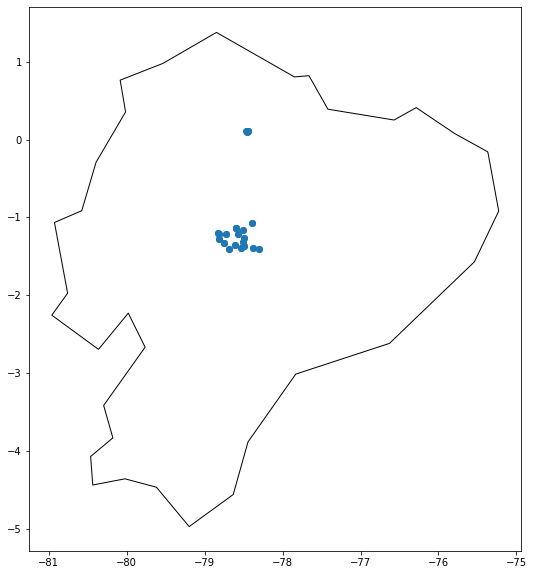

In [24]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
SA = world.query('name == "Ecuador"')
gdf4326 = gdf.to_crs(world.crs)

fig, ax = plt.subplots(figsize=(10,10))
ax.set_aspect('equal')
SA.plot(ax=ax, color='white', edgecolor='black')
gdf4326.plot(ax=ax)
# for i in range(df.shape[0]):
#     plt.text(x=gdf4326.lon_deg[i]+0.1,y=gdf4326.lat_deg[i]+0.1,s=gdf4326.nombre[i], 
#           fontdict=dict(color='black',size=10),
#           bbox=dict(facecolor='yellow',alpha=0.5))

plt.show()

In [26]:
df[df.nombre.str.match('^[Bb][Aa][Ññ][Oo][Ss]')].drop(columns ='parametros_medicion')

,fuente,numero,codigo,nombre,tipo,provincia,estado,fecha_instalacion,latitud,longitud,lon_deg,lat_deg,geometry
0,esta_inamhi,1,M0029,BAÑOS,CP,TUNGURAHUA,FUNCIONANDO,20-jun-62,12329.0,782505.0,-78.462030,0.111434,POINT (-78.46203 0.11143)
16,esta_hgpt,6,HGPT_MT-0006,Baños,MA,TUNGURAHUA,FUNCIONANDO,February-13,9845439.0,791471.0,-78.380768,-1.396889,POINT (-78.38077 -1.39689)
35,esta_hgpt_sen,6,HGPT_MT-0006,Baños,MA,TUNGURAHUA,FUNCIONANDO,February-13,9845439.0,791471.0,-78.380768,-1.396889,POINT (-78.38077 -1.39689)


#### Automate data extraction from Drive downloads

In [115]:
path = '/Users/tamarahuete/Documents/Github_repos/TFM21/data'
ziplist = glob.glob(f'{path}/*.zip')
#ziplist = glob.glob(f'data/*.zip')

In [116]:
ziplist

['/Users/tamarahuete/Documents/Github_repos/TFM21/data/07-HGPT-MT-07.- Estacion Aeropuerto-20210505T205931Z-001.zip',
 '/Users/tamarahuete/Documents/Github_repos/TFM21/data/02-HGPT-MT-06.- Estacion Baños-20210426T162523Z-001.zip']

In [149]:
zf = zipfile.ZipFile(f'{ziplist[0]}')
zf.namelist()[0:5]

['07-HGPT-MT-07.- Estacion Aeropuerto/2013-06-13/Aeropuerto_5min_20130624.csv',
 '07-HGPT-MT-07.- Estacion Aeropuerto/2018-01-11/8310_5min_20180116.csv',
 '07-HGPT-MT-07.- Estacion Aeropuerto/2013-06-13/8310_1min_20170404.csv',
 '07-HGPT-MT-07.- Estacion Aeropuerto/2015-07-02/8310_5min_20150714_subir.csv',
 '07-HGPT-MT-07.- Estacion Aeropuerto/2018-01-11/8310_5min_20180116_subir.csv']

In [147]:
## order files and skip resumen and xls sheets
files_by_date = order_meteo_zip(path, folder = 0)

In [157]:
files_by_date[0:5]  ### the filenames may be wrong, the order is done following the folder date

['07-HGPT-MT-07.- Estacion Aeropuerto/2013-03-26/8310_1min_20170404.csv',
 '07-HGPT-MT-07.- Estacion Aeropuerto/2013-03-26/Aeropuerto_1hora_20130517.csv',
 '07-HGPT-MT-07.- Estacion Aeropuerto/2013-05-07/8310_1min_20170404.csv',
 '07-HGPT-MT-07.- Estacion Aeropuerto/2013-05-07/Aeropuerto_5min_20140417.csv',
 '07-HGPT-MT-07.- Estacion Aeropuerto/2013-06-13/Aeropuerto_5min_20130624.csv']

In [187]:
df = read_meteo_csv(path =path,folder = 0,file = files_by_date[0])

Success regular csv, no header, latin encoding
file =07-HGPT-MT-07.- Estacion Aeropuerto/2013-03-26/8310_1min_20170404.csv, cols = 6


In [190]:
df.head()

,Date,Time,Variable,Value,type,Freq
0,03/19/2013,21:18:00,TB1minAcc,0.00,G,5min
1,03/19/2013,21:18:00,RHAvg,91.10,G,5min
2,03/19/2013,21:18:00,ATAvg,10.07,G,5min
3,03/19/2013,21:19:00,TB1minAcc,0.00,G,5min
4,03/19/2013,21:19:00,RHAvg,92.39,G,5min


In [169]:
all_var = get_unique_variables(files_by_date, export_name='summary_aeropuerto.csv')

Success regular csv, no header, latin encoding
file =07-HGPT-MT-07.- Estacion Aeropuerto/2013-03-26/8310_1min_20170404.csv, cols = 5
Success sep ";", latin encoding
file =07-HGPT-MT-07.- Estacion Aeropuerto/2013-03-26/Aeropuerto_1hora_20130517.csv, cols = 5
Success regular csv, no header, latin encoding
file =07-HGPT-MT-07.- Estacion Aeropuerto/2013-05-07/8310_1min_20170404.csv, cols = 5
Success sep ";", latin encoding
file =07-HGPT-MT-07.- Estacion Aeropuerto/2013-05-07/Aeropuerto_5min_20140417.csv, cols = 5
Success sep ";", latin encoding
file =07-HGPT-MT-07.- Estacion Aeropuerto/2013-06-13/Aeropuerto_5min_20130624.csv, cols = 5


In [16]:
## Variable names:

# What are 'TB1hrAcc','TB1minAcc','TB5minAcc','BAT'?

replace_values ={
# Temperature
    'ATAvg' :['AT1HrAvg', 'AT5minAvg', 'ATAvg','Temperatura'],
    'ATMin' : ['AT1HrMin', 'AT5minMin','T_Min'],
    'ATMax' : ['AT1HrMax','AT5minMax', 'T_Max'],
 
 # Relative Humidity
    'RHAvg' : ['Humedad','RH5minAvg','RHAvg','RelHumidAvg'],
    'RHMin' : ['H_Min','RH5minMin','RelHumidMin'],
    'RHMax' : ['H_Max', 'RH5minMax', 'RelHumidMax'],

 # Wind Speed
    'WSAvg' : ['Velocidad','WS5minAvg','WSAvg','WindMnSpdSclr'],
    'WSMin' : ['WindMinSpdSclr','WS5minMin'],
    'WSMax' : ['WindMaxSpdSclr','WS5minMax'],

 # Wind Direction
    'WDAvg' : ['Direccion', 'WDAvg','WD5minAvg','WindMnDirUnit'],
    'WDMin' : ['WD5minMin'],
    'WDMax' : ['WD5minMax','WindMaxDir'],

 # Rain
    'PAvg' : ['Precipitacion']
}

var_list = ['ATAvg','ATMin','ATMax','RHAvg','RHMin','RHMax', 'WSAvg','WSMin','WSMax','WDAvg','WDMin', 'WDMax','PAvg','TB1hrAcc','TB1minAcc','TB5minAcc','BAT']
sorted(var_list)

In [198]:
def reformat_df(df, replace_values):
    
    ## replace variables
    for variable in list(replace_values.keys()):
        df =df.replace(to_replace =replace_values[variable], value = variable)
    
    ## delete any empty rows
    df.dropna(inplace=True)
        
    ## merge date + time
    df['Date_Time']= pd.to_datetime(df['Date'] + ' ' + df['Time'])
    df.drop(columns =['Date','Time'],inplace =True)
    
    #Convert to long format
    df = df.pivot(index='Date_Time', columns='Variable', values='Value').reset_index()
    
    ## Add variables that are not in the df but are in the general list
    not_in_df = list(set(var_list)-set(df.columns))
    for i in not_in_df:
        df[i]=np.nan
    
    ## Order columns so all dfs have the same structure
    var_order = ['Date_Time']
    var_order.extend(sorted(df.loc[:,df.columns != 'Date_Time'].columns))
    df.reindex(var_order, axis=1)
    
    return df

In [199]:
df2 = reformat_df(df=df, replace_values=replace_values)

In [211]:
df['Date_Time']= pd.to_datetime(df['Date'] + ' ' + df['Time'])
df.pivot(index='Date_Time', columns='Variable', values='Value').reset_index()

Variable,Date_Time,ATAvg,RHAvg,TB1minAcc
0,2013-03-19 21:18:00,10.07,91.10,0.0
1,2013-03-19 21:19:00,10.17,92.39,0.0
2,2013-03-19 21:20:00,10.20,91.66,0.0
3,2013-03-19 21:21:00,10.05,91.80,0.0
4,2013-03-19 21:22:00,10.03,92.58,0.0
...,...,...,...,...
9504,2013-03-26 11:42:00,15.81,80.41,0.0
9505,2013-03-26 11:43:00,15.84,80.65,0.0
9506,2013-03-26 11:44:00,15.80,80.85,0.0
9507,2013-03-26 11:45:00,15.86,81.30,0.0


In [202]:
df.pivot(index=['Date_Time','Freq'], columns='Variable', values='Value')

KeyError: "['Date_Time'] not in index"

In [ ]:
### next step: How to keep all columns with pivoy or use group by

In [ ]:
### Convert to long format
#df.melt(id_vars='Fecha', value_vars=list(df.columns)[1:], var_name='Variable', value_name='value')